# Predictive model: Business Use Case

## Goal

- Using the available [Road Safety Data](https://www.data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data) create a predictive modeling business use case
- Desired use case: **On-premise forecast of *dangarous* traffic situations**
- Train model capable to predict accident severity "score": Overall accident severity

## Considerations

- Take all available information into account including spatiotemporal, environmental, vehicle
- Important when defining features: 
    - Only features available *before* accident can be used
    - Do not utilize features not to be used in practice, e.g. 
        - due to GDPR (driver properties)
        - busincess-strategic (car model name)

In [1]:
import os
import pandas
import mlflow
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

from workflows.helpers.utils import (
    load_yaml,
    infer_catboost_feature_types,
    read_partitioned_pandas_asset
)

from sklearn import set_config
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.model_selection import ShuffleSplit

from catboost import CatBoostRegressor, Pool

set_config(transform_output="pandas")
assets_dir = Path(os.environ["DATA_DIR"]) / "assets"

In [2]:
X = read_partitioned_pandas_asset("accidents_vehicles_casualties_preprocessed")
X = X.iloc[:10000]
y = X.pop("target")

## Properties Visualization

<Axes: title={'center': 'Severity score counts'}, xlabel='target', ylabel='Count'>

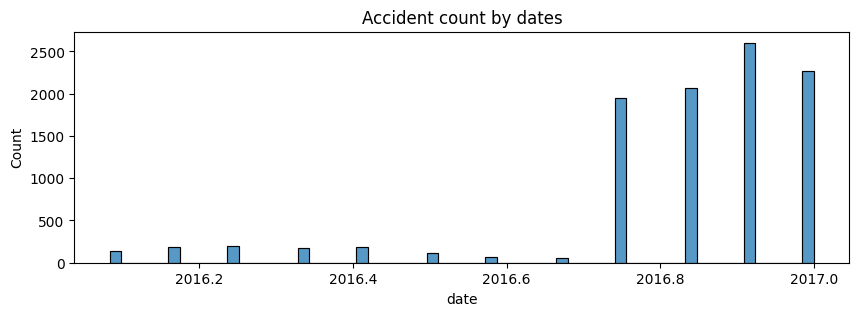

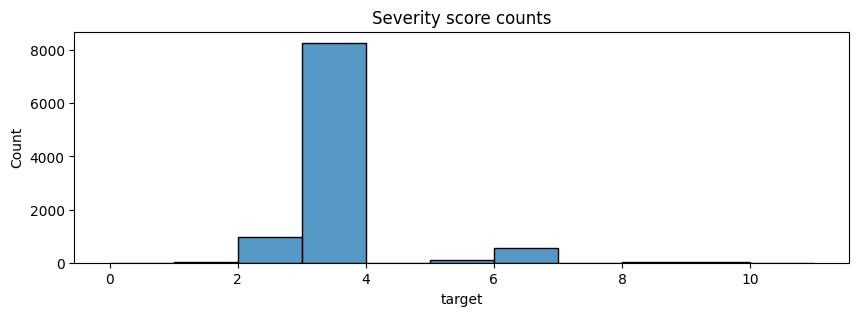

In [3]:
date = (X["accident.year"] + X["accident.month"] / 12)
date.name = "date"
date = date.to_frame()
date["count"] = 1

# Accident counts
f_count, ax = plt.subplots(figsize=(10, 3))
ax.set_title("Accident count by dates")
sns.histplot(date, x="date", ax=ax)

# Severity score counts
f_score, ax = plt.subplots(figsize=(10, 3))
ax.set_title("Severity score counts")
sns.histplot(y, bins=range(0, int(max(y))), ax=ax)

## Training and logging

- Define model parameters
- Apply training rounds and log params and metrics to tracking server
- Log trained model as model artifact

In [4]:
feat = infer_catboost_feature_types(X)

catboost_init_params = {
    "cat_features": feat["categorical"], 
    "text_features": feat["text"], 
    "od_type": "Iter", 
    "iterations": 400,
    "train_dir": "/tmp/catboost"
}

catboost_fit_params = {
    "early_stopping_rounds": 101,
    "verbose": 100
}

model = CatBoostRegressor(**catboost_init_params)

In [5]:
mlflow.set_registry_uri(os.environ["MLFLOW_TRACKING_URI"])
mlflow.set_experiment("casualty-regression")

2023/08/01 18:16:12 INFO mlflow.tracking.fluent: Experiment with name 'casualty-regression' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlflow-bucket/163716316543264412', creation_time=1690913772894, experiment_id='163716316543264412', last_update_time=1690913772894, lifecycle_stage='active', name='casualty-regression', tags={}>

In [6]:
with mlflow.start_run() as run:
    
    run_id = run.info.run_id

    mlflow.log_figure(f_count, "count_by_date.png")
    mlflow.log_figure(f_score, "score_count.png")
    mlflow.log_params(catboost_init_params)
    mlflow.log_params(catboost_fit_params)
    mlflow.log_param("n_accidents", len(X))

    splitter = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    
    for train, test in splitter.split(X):
        Xtrain = X.iloc[train]
        ytrain = y.iloc[train]

        data_test = Pool(
            X.iloc[test], 
            y.iloc[test], 
            text_features=feat["text"],
            cat_features=feat["categorical"]
        )

        train, val = next(
            ShuffleSplit(n_splits=1, test_size=0.05, random_state=42)
            .split(Xtrain)
        )

        data_val = Pool(
            X.iloc[val], 
            y.iloc[val], 
            text_features=feat["text"],
            cat_features=feat["categorical"]
        )

        data_train = Pool(
            X.iloc[train], 
            y.iloc[train], 
            text_features=feat["text"],
            cat_features=feat["categorical"]
        )

        model.fit(data_train, eval_set=data_val, **catboost_fit_params)

        ypred = model.predict(data_test)
        
        mae = mean_absolute_error(data_test.get_label(), ypred)
        mse = mean_squared_error(data_test.get_label(), ypred)
        
        mlflow.log_metrics(
            {
                "mae": mae,
                "mse": mse
            }
        )

        # Confusion matrix
        confusion = pandas.DataFrame(
            confusion_matrix(
                data_test.get_label(), 
                np.round(ypred, 0).astype(int)
            )
        )
        confusion.to_csv("/tmp/confusion.csv")
        mlflow.log_artifact("/tmp/confusion.csv")

Learning rate set to 0.122441
0:	learn: 0.8960063	test: 0.8990769	best: 0.8990769 (0)	total: 62.4ms	remaining: 24.9s
100:	learn: 0.7272283	test: 0.8685932	best: 0.8660259 (46)	total: 1.56s	remaining: 4.63s
Stopped by overfitting detector  (101 iterations wait)

bestTest = 0.8660259201
bestIteration = 46

Shrink model to first 47 iterations.


In [7]:
with mlflow.start_run(run_id=run_id):
    # Log model artifact
    model.fit(X, y, **catboost_fit_params)
    mlflow.catboost.log_model(model, artifact_path="model")

Learning rate set to 0.124081
0:	learn: 0.8856860	total: 54.5ms	remaining: 21.7s
100:	learn: 0.7269228	total: 2.37s	remaining: 7.01s
200:	learn: 0.6664551	total: 4.88s	remaining: 4.84s
300:	learn: 0.6237898	total: 7.14s	remaining: 2.35s
399:	learn: 0.5850416	total: 9.76s	remaining: 0us


In [8]:
mlflow.register_model(
    model_uri=f"runs:/{run_id}/model",
    name="accident-severity"
)

Successfully registered model 'accident-severity'.
2023/08/01 18:16:29 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: accident-severity, version 1
Created version '1' of model 'accident-severity'.


<ModelVersion: aliases=[], creation_timestamp=1690913789896, current_stage='None', description='', last_updated_timestamp=1690913789896, name='accident-severity', run_id='9304133923214c74b5f435c08c371955', run_link='', source='s3://mlflow-bucket/163716316543264412/9304133923214c74b5f435c08c371955/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>